# Zones soumises à un risque d'innondation

#### Imports

In [63]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from datetime import datetime, timedelta
import glob

# Set notebook mode to work in offline
pio.renderers.default = 'iframe+pdf'

#### API STATIONS

On récupères les stations hydrométriques en fonctionnement:

In [2]:
url_stations = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/referentiel/stations"

response_stations = requests.get(url_stations, params={"size": 6000})
if response_stations.status_code == '200' or '206': # status codes are detailed on the website
    data_stations = response_stations.json()
    data_stations = pd.DataFrame(data_stations["data"])
else:
    print(f"La requête a échoué avec le code d'état {response_stations.status_code}")

# We check the names of the columns that contain at least 50% of null values
data_stations.isnull().sum()

# We remove the columns that contain at least 50% of null values
data_stations = data_stations.dropna(axis=1, thresh=int(0.5*len(data_stations)))

# We remove every row that is not in metropolitan france
regions_in_metropolitan_france = ['GRAND EST', 'HAUTS-DE-FRANCE', 'BOURGOGNE-FRANCHE-COMTE', 'ILE-DE-FRANCE', 'CENTRE-VAL DE LOIRE', 'NORMANDIE', 'BRETAGNE', 'PAYS DE LA LOIRE', 'AUVERGNE-RHONE-ALPES', 'OCCITANIE', 'NOUVELLE-AQUITAINE', "PROVENCE-ALPES-COTE D'AZUR", 'CORSE']
data_stations = data_stations[data_stations["libelle_region"].isin(regions_in_metropolitan_france)]

# Next, we remove every row where the corresponding station is not active
data_stations = data_stations[data_stations["en_service"] == True]

# We remove every row where the longitude is between -15 and 40
data_stations = data_stations[(data_stations["longitude_station"] > -15) & (data_stations["longitude_station"] < 40)]

print("Il y a",len(data_stations),"stations en fonctionnement.")

Il y a 3450 stations en fonctionnement.


On sélectionne les stations pour lesquelles on connait le seuil limite de hauteur (max)

###### Voir code qui a permis de scraper les seuils car pas d'API disponible...

In [81]:
# Les stations dont on a pu récupérer le seuil sont enregistrées dans des fichiers csv
dossier = '/home/louiscockenpot/Documents/real-time-flood-alerts/data_limites'

fichiers_csv = glob.glob(dossier + '/data*')

codes = []
for fichier in fichiers_csv:
    codes.append(fichier.split("_")[-1])

print("Il y a",len(codes)," stations exploitables.")

Il y a 2588  stations exploitables.


Visualisation des stations:

In [82]:
data_stations_final = data_stations.loc[data_stations['code_station'].isin(codes)]

In [83]:
fig = px.scatter_mapbox(data_stations_final,lat='latitude_station',lon='longitude_station', zoom=4, center={'lat': 46.5, 'lon': 2.7274})
fig.update_layout(title='Stations exploitables', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')
fig.show()

### Le but est de trouver les stations ou le niveau d'eau atteint 95% du seuil mis en place.

On récupère les infos hydrométriques de ces stations. (10 requêtes): (l'API utilisée ci dessous ne fournit pas de résultat sur une date antiérieure à un mois de la date actuelle)

In [57]:
url = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/observations_tr"
stations = data_stations_final['code_station'].tolist()

date = datetime.now()-timedelta(hours=24) # On récupères toutes les observations des 24 dernières heures
date = date.strftime("%Y-%m-%dT%H:%M:%S")

data_hydro = pd.DataFrame()

for i in range(0,len(stations),75):
    params = {
        "code_entite": stations[i:i+75], # station code    
        "date_debut_obs": date,        
        "grandeur_hydro": ['Q'], # hydrometric variables choosen
        "size": 20000
        #"timestep": 20
    }
    
    response = requests.get(url, params=params)
    
    print("status code:",response.status_code)
    
    if response.status_code == (200 or 206): # status codes are detailed on the website
        data = response.json()        
        data_hydro_temp = pd.DataFrame(data["data"])
        data_hydro = pd.concat([data_hydro,data_hydro_temp], ignore_index=True)
    else:
        print(f"La requête a échoué avec le code d'état {response.status_code}")

status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200


OLD: On récupère uniquement la dernière observation pour chaque station:

On fait la moyenne des observations:

In [50]:
mean_obs = latest_obs_per_site.groupby("code_station")[['resultat_obs','latitude','longitude']].mean().reset_index()

Finalement, on regarde les stations dont la hauteur d'eau est à 95% du seuil maximal:

In [139]:
import datetime

data_hydro_ALERT = pd.DataFrame()

for index, row in mean_obs.iterrows():
    code_station = row['code_station']
    mois_actuel = datetime.datetime.now().month
    try:
        data_seuil_station = pd.read_csv(f'data_limites/data_limites_{code_station}')
        data_seuil_station['QmM  Débit moyen mensuel (en l/s)'] = data_seuil_station['QmM  Débit moyen mensuel (en l/s)'].astype(int)        
        moyenne_mois_acutel = data_seuil_station.iloc[mois_actuel]['QmM  Débit moyen mensuel (en l/s)']
            
        if row['resultat_obs'] > moyenne_mois_acutel*4:
            data_hydro_ALERT = pd.concat([data_hydro_ALERT,mean_obs.loc[mean_obs['code_station']==row['code_station']]],ignore_index=True)
    except:
        pass
        
data_hydro_ALERT.head()

,code_station,resultat_obs,latitude,longitude
0,A842020101,677.0,49.285515,6.003351
1,A891030101,282.0,49.445259,6.024385
2,H150391001,469.0,48.580464,4.103726
3,K277801002,262.0,45.878865,3.068009
4,L242401002,818.0,46.657725,0.076656


Visualisation de ces stations:

In [140]:
fig = px.scatter_mapbox(data_hydro_ALERT, lat='latitude', lon='longitude', zoom=4, center={'lat': 46.5, 'lon': 2.7274}) 
fig.update_layout(title='Zones à risque', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')
fig.show()

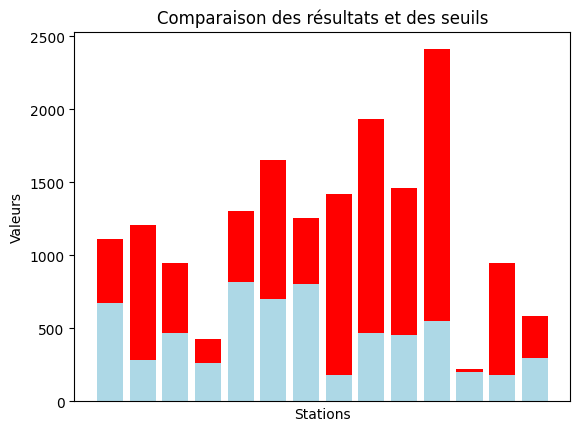

In [141]:
seuils1bis = {}
for code in data_hydro_ALERT['code_station']:
    seuils1bis[code] = seuils[code]
seuils_df = pd.DataFrame.from_dict(seuils1bis, orient='index', columns=['Seuils']).reset_index()
seuils_df['Seuils'] =seuils_df['Seuils'].astype(int)

plt.bar(seuils_df['index'], seuils_df['Seuils'], color='red')
plt.bar(data_hydro_ALERT['code_station'], data_hydro_ALERT['resultat_obs'], color='lightblue')
plt.title('Comparaison des résultats et des seuils')
plt.xticks([])
plt.xlabel('Stations')
plt.ylabel('Valeurs')
plt.show()

### Même process pour le débit (QmJ):

On sélectionne les stations pour lesquelles on connait le seuil limite de débit (max)

In [11]:
with open("stations2.txt",'r') as file:
    seuils2 = {}
    for line in file:
        cle, valeur = line.strip().split(':')        
        seuils2[cle] = valeur

        
code_sites2 = list(seuils2.keys())
print("Il y a",len(seuils2),"stations pour lesquelles on a le seuil limite maximum (débit)")

Il y a 2655 stations pour lesquelles on a le seuil limite maximum (débit)


Visualisation des stations

In [12]:
data_stations_final2 = data_stations.loc[data_stations['code_station'].isin(code_sites2)]
fig = px.scatter_mapbox(data_stations_final2,lat='latitude_station',lon='longitude_station', zoom=4, center={'lat': 46.5, 'lon': 2.7274})
fig.update_layout(title='Stations exploitables (débit)', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')
fig.show()

Test avec une autre API pour comparer avec des crues historiques: (seul les infos de débit sont dispo sur cette api)

In [13]:
url2 = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/obs_elab"
stations2 = data_stations_final2['code_station'].tolist()

#date = datetime.now()-timedelta(hours=5)
#date = date.strftime("%Y-%m-%dT%H:%M:%S")

date_deb_crue = datetime(2003, 12, 3)
date_fin_crue = datetime(2003, 12, 4)

data_hydro2 = pd.DataFrame()

for i in range(0,len(stations2),99):
    params = {
        "code_entite": stations2[i:i+99], # station code    
        "date_debut_obs_elab": date_deb_crue,
        "date_fin_obs_elab": date_fin_crue,
        "grandeur_hydro_elab": ['QmJ'], # hydrometric variables choosen
        "size": 20000,
        "resultat_min": 0
        #"timestep": 20
    }
    
    response = requests.get(url2, params=params)
    
    print("status code:",response.status_code)
    
    if response.status_code == (200 or 206): # status codes are detailed on the website
        data = response.json()        
        data_hydro_temp = pd.DataFrame(data["data"])
        data_hydro2 = pd.concat([data_hydro2,data_hydro_temp], ignore_index=True)
    else:
        print(f"La requête a échoué avec le code d'état {response.status_code}")

status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200


On regarde les stations dont le débit d'eau est dessus du seuil maximal:

In [14]:
# On récupère uniquement la dernière observation pour chaque station:
data_hydro2['date_obs_elab'] = pd.to_datetime(data_hydro2['date_obs_elab'])
data_hydro_sorted2 = data_hydro2.sort_values(by=['code_station', 'date_obs_elab'], ascending=[True, False])
latest_obs_per_site2 = data_hydro_sorted2.groupby('code_station').apply(lambda x: x.loc[x['date_obs_elab'].idxmax()])
latest_obs_per_site2 = latest_obs_per_site2.reset_index(drop=True)

# On regarde les stations dont le débit d'eau est dessus du seuil maximal:
data_hydro_ALERT2 = pd.DataFrame()
for index, row in latest_obs_per_site2.iterrows():
    if row['resultat_obs_elab'] > float(seuils2[row['code_station']])*0.6:
        data_hydro_ALERT2 = pd.concat([data_hydro_ALERT2,latest_obs_per_site2.loc[latest_obs_per_site2['code_station']==row['code_station']]],ignore_index=True)

data_hydro_ALERT2.head()

,code_site,code_station,date_obs_elab,resultat_obs_elab,date_prod,code_statut,libelle_statut,code_methode,libelle_methode,code_qualification,libelle_qualification,longitude,latitude,grandeur_hydro_elab
0,A2430030,A243003001,2003-12-04,40233.0,2021-09-15T18:04:40Z,16,Donnée validée,12,Interpolation,20,Bonne,7.704857,48.488762,QmJ
1,A6921010,A692101001,2003-12-04,12159.0,2021-09-15T07:18:19Z,16,Donnée validée,12,Interpolation,20,Bonne,6.272227,48.642507,QmJ
2,K0910010,K091001010,2003-12-04,1573538.0,2022-07-26T10:07:40Z,16,Donnée validée,12,Interpolation,20,Bonne,4.041950,46.001550,QmJ
3,K1180010,K118001010,2003-12-04,1684548.0,2022-07-26T10:03:28Z,16,Donnée validée,12,Interpolation,20,Bonne,3.983036,46.478169,QmJ
4,K1391810,K139181001,2003-12-04,317751.0,2023-02-24T15:20:06Z,16,Donnée validée,12,Interpolation,20,Bonne,3.989245,46.494964,QmJ


In [154]:
import datetime

data_hydro2['date_obs_elab'] = pd.to_datetime(data_hydro2['date_obs_elab'])
data_hydro_sorted2 = data_hydro2.sort_values(by=['code_station', 'date_obs_elab'], ascending=[True, False])
latest_obs_per_site2 = data_hydro_sorted2.groupby('code_station').apply(lambda x: x.loc[x['date_obs_elab'].idxmax()])
latest_obs_per_site2 = latest_obs_per_site2.reset_index(drop=True)

data_hydro_ALERT2 = pd.DataFrame()

for index, row in latest_obs_per_site2.iterrows():
    code_station = row['code_station']
    mois_actuel = datetime.datetime.now().month
    try:
        data_seuil_station = pd.read_csv(f'data_limites/data_limites_{code_station}')
        data_seuil_station['QmM  Débit moyen mensuel (en l/s)'] = data_seuil_station['QmM  Débit moyen mensuel (en l/s)'].astype(int)        
        moyenne_mois_acutel = data_seuil_station.iloc[mois_actuel]['QmM  Débit moyen mensuel (en l/s)']
            
        if row['resultat_obs_elab'] > moyenne_mois_acutel*4:
            data_hydro_ALERT2 = pd.concat([data_hydro_ALERT2,latest_obs_per_site2.loc[latest_obs_per_site2['code_station']==row['code_station']]],ignore_index=True)
    except:
        pass
        
data_hydro_ALERT2.head()

,code_site,code_station,date_obs_elab,resultat_obs_elab,date_prod,code_statut,libelle_statut,code_methode,libelle_methode,code_qualification,libelle_qualification,longitude,latitude,grandeur_hydro_elab
0,K0258010,K025801001,2003-12-04,9452.0,2021-09-15T01:08:34Z,12,Donnée pré-validée,12,Interpolation,20,Bonne,3.862478,45.024229,QmJ
1,K0568310,K056831001,2003-12-04,556.0,2021-09-16T19:21:48Z,16,Donnée validée,12,Interpolation,20,Bonne,4.385963,45.273645,QmJ
2,K0663310,K066331001,2003-12-04,6867.0,2021-09-15T21:02:23Z,16,Donnée validée,12,Interpolation,20,Bonne,4.525248,45.628021,QmJ
3,K0704510,K070451001,2003-12-04,4355.0,2022-03-09T09:25:23Z,16,Donnée validée,12,Interpolation,20,Bonne,4.295393,45.673266,QmJ
4,K0724510,K072451001,2003-12-04,1005.0,2021-09-16T13:59:32Z,16,Donnée validée,12,Interpolation,20,Bonne,4.243754,45.785477,QmJ


Visualisation de ces stations

In [156]:
fig = px.scatter_mapbox(data_hydro_ALERT2, lat='latitude', lon='longitude', zoom=4, center={'lat': 46.5, 'lon': 2.7274}) 
fig.update_layout(title='Zones à risque', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')
fig.show()

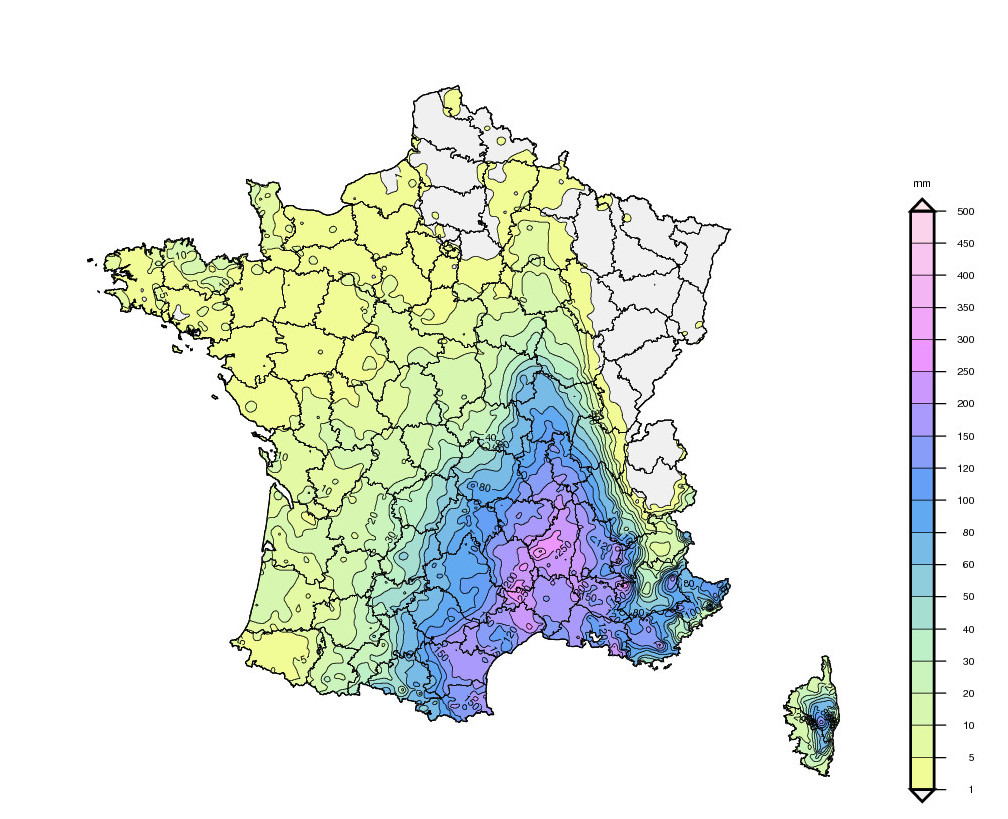

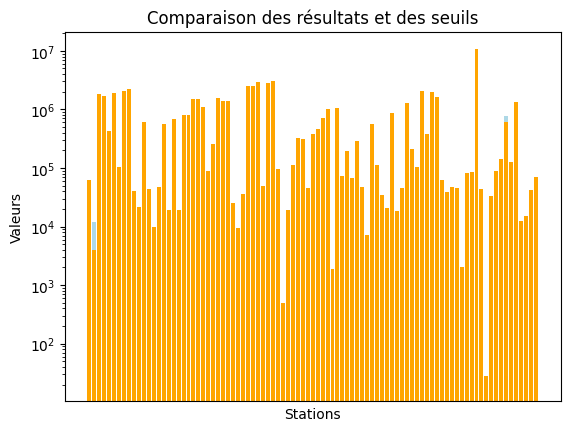

In [16]:
seuils2bis = {}
for code in data_hydro_ALERT2['code_station']:
    seuils2bis[code] = seuils2[code]
seuils2_df = pd.DataFrame.from_dict(seuils2bis, orient='index', columns=['Seuils']).reset_index()
seuils2_df['Seuils'] =seuils2_df['Seuils'].astype(int)

plt.bar(data_hydro_ALERT2['code_station'], data_hydro_ALERT2['resultat_obs_elab'], color='lightblue')
plt.bar(seuils2_df['index'], seuils2_df['Seuils'], color='orange')
plt.title('Comparaison des résultats et des seuils')
plt.xticks([])
plt.yscale('log')
plt.xlabel("Stations")
plt.ylabel('Valeurs')
plt.show()